# Mahalanobis Threshold and Results
___

The following notebook includes the following steps:

- Initialize function for covariance matrix, Mahalanobis distance, and Mahalanobis threshold
- Graph Mahalanobis distance for each instance to visualize anamoly runs

In [33]:
# Check to see if matrix is positive definite
def is_pos_def(A):
    if np.allclose(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

In [34]:
# Calculate the Covariance Matrix
def cov_matrix(data, verbose=False):
    covariance_matrix = np.cov(data, rowvar=False)
    if is_pos_def(covariance_matrix):
        inv_covariance_matrix = np.linalg.inv(covariance_matrix)
        if is_pos_def(inv_covariance_matrix):
            return covariance_matrix, inv_covariance_matrix
        else:
            print("Error: Inverse of Covariance Matrix is not positive definite!")
    else:
        print("Error: Covariance Matrix is not positive definite!")

In [35]:
# Calculate the Mahalanobis Distance
def MahalanobisDist(inv_cov_matrix, mean_distr, data, verbose=False):
    inv_covariance_matrix = inv_cov_matrix
    vars_mean = mean_distr
    diff = data - vars_mean
    md = []
    for i in range(len(diff)):
        md.append(np.sqrt(diff[i].dot(inv_covariance_matrix).dot(diff[i])))
    return md

In [37]:
# Calculate the threshold for classifying a datapoint as an anomaly
def MD_threshold(dist, extreme=False, verbose=False):
    k = 1.6 if extreme else 2. #1.6 for MaxAbsScalar
    threshold = np.mean(dist) * k
    return threshold

In [38]:
# Define train/test set from the two main principal components:
data_train = np.array(X_train_PCA.values)
data_test = np.array(X_test_PCA.values)

In [39]:
# Calculate the covariance matrix and its inverse, based on data in the training set
cov_matrix, inv_cov_matrix  = cov_matrix(data_train)

In [40]:
# calculate the mean value for the input variables in the training set, as this is used later to calculate the Mahalanobis distance to datapoints in the test set
mean_distr_train = data_train.mean(axis=0)
mean_distr_test = data_test.mean(axis=0)

In [41]:
# Calculate the Mahalanobis distance for the training data defining “normal conditions”, and find the threshold value to flag datapoints as an anomaly.
# Then calculate the Mahalanobis distance for the datapoints in the test set, and compare that with the anomaly threshold.
dist_test = MahalanobisDist(inv_cov_matrix, mean_distr_test, data_test, verbose=False)
dist_train = MahalanobisDist(inv_cov_matrix, mean_distr_train, data_train, verbose=False)
threshold = MD_threshold(dist_train, extreme = True)

C:\Users\Kyle\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 15.0)

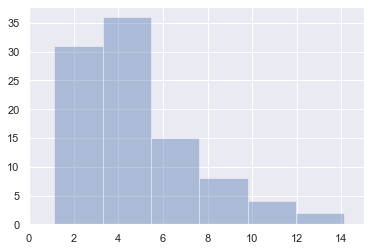

In [42]:
# visualizing the square of the Mahalanobis distance
plt.figure()
sns.distplot(np.square(dist_train),
             bins = 10, 
             kde= False)
plt.xlim([0.0,15])

Text(0.5, 0, 'Mahalanobis dist')

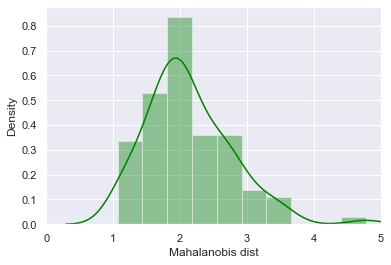

In [43]:
# visualize the Mahalanobis distance itself
plt.figure()
sns.distplot(dist_train,
             bins = 10, 
             kde= True, 
            color = 'green')
plt.xlim([0.0,5])
plt.xlabel('Mahalanobis dist')

In [44]:
# save the Mahalanobis distance, as well as the threshold value and “anomaly flag” variable for both train and test data in a dataframe
anomaly_train = pd.DataFrame()
anomaly_train['Mob dist']= dist_train
anomaly_train['Thresh'] = threshold
# If Mob dist above threshold: Flag as anomaly
anomaly_train['Anomaly'] = anomaly_train['Mob dist'] > anomaly_train['Thresh']
#anomaly_train['Anomaly'] = anomaly_train['Anomaly'].astype(float)
anomaly_train.index = X_train_PCA.index
anomaly = pd.DataFrame()
anomaly['Mob dist']= dist_test
anomaly['Thresh'] = threshold
# If Mob dist above threshold: Flag as anomaly
anomaly['Anomaly'] = anomaly['Mob dist'] > anomaly['Thresh']
#anomaly['Anomaly'] = anomaly['Anomaly'].astype(float)
anomaly.index = X_test_PCA.index
anomaly.head()

#convert y_train/y_test to boolean
y_train = y_train.astype(bool)
y_test = y_test.astype(bool)

In [45]:
#creating metric function 

def metrics_score(actual, predicted):
    print(classification_report(actual, predicted))
    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize=(8,5))
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels=['Not Anomaly', 'Anomaly'], yticklabels=['Not Anomaly', 'Anomaly'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

              precision    recall  f1-score   support

       False       1.00      0.96      0.98        96
        True       0.20      1.00      0.33         1

    accuracy                           0.96        97
   macro avg       0.60      0.98      0.66        97
weighted avg       0.99      0.96      0.97        97



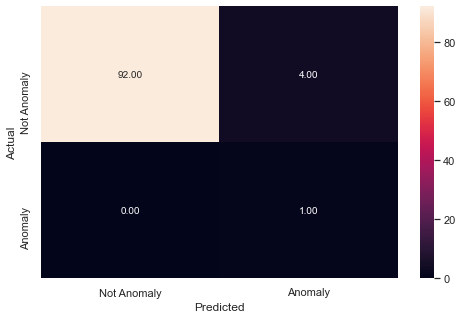

In [46]:
#checking performance on train dataset
y_train_pred_dt=anomaly_train.loc['12-9200':'12-9300',"Anomaly"]

#y_train_pred_dt=anomaly_train.loc['12-9263':'12-9325',"Anomaly"]
metrics_score(y_train,y_train_pred_dt)

              precision    recall  f1-score   support

       False       0.98      0.89      0.93        63
        True       0.50      0.88      0.64         8

    accuracy                           0.89        71
   macro avg       0.74      0.88      0.78        71
weighted avg       0.93      0.89      0.90        71



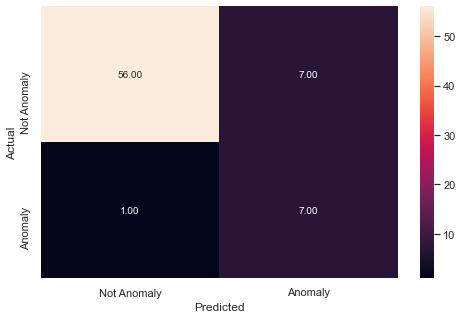

In [47]:
#checking performance on test dataset
y_test_pred_dt=anomaly.loc['12-9301':'12-9370',"Anomaly"]

#y_test_pred_dt=anomaly.loc['12-9326':,"Anomaly"]
metrics_score(y_test,y_test_pred_dt)

In [48]:
#  merge the data in a single dataframe and save it as a .csv file
import csv
anomaly_alldata = pd.concat([anomaly_train, anomaly])
anomaly_alldata.to_csv('Anomaly_distance.csv')
# anomaly_alldata = anomaly_train
# anomaly_alldata.to_csv('Anomaly_distance.csv')

Text(0.5, 1.0, 'Anomaly Detection')

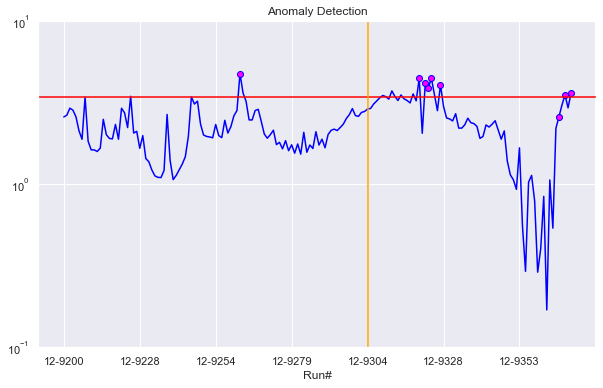

In [49]:
dates = ["12-9262","12-9321","12-9323","12-9324","12-9325","12-9327","12-9366","12-9368","12-9370"]
def find_loc(anomaly_alldata, dates):
    marks = []
    for date in dates:
        marks.append(anomaly_alldata.index.get_loc(date))
    return marks

# plot the calculated anomaly metric (Mob dist), and check when it crosses the anomaly threshold (note the logarithmic y-axis)
anomaly_alldata['Mob dist'].plot(logy=True, figsize = (10,6), ylim = [1e-1,1e1], color = ['Blue'], markevery=find_loc(anomaly_alldata['Mob dist'], dates), marker='o', markerfacecolor='magenta')
plt.axhline(y = 3.40799769954337, color = 'red', linestyle = '-')
plt.axvline(x=100,color='orange')
plt.title('Anomaly Detection')